# **Mammographic Region Proposal Algorithms** for Training <br> Support Vector Machines and Convolutional Neural Networks

Contributors: Jaime Simarro Viana, Zohaib Salahuddin, Ahmed Gouda, Anindo Saha

References: <br>
● Hang M. et al. (2019) "*Multi-Scale Sifting for Mammographic Mass Detection and Segmentation*", Biomedical Physics & Engineering Express, 5-2. DOI:10.1088/2057-1976/aafc07 <br>
● Radhakrishna A. et al. (2010) "*SLIC Superpixels Compared to State-of-the-Art Superpixel Methods*", IEEE TPAMI. DOI:10.1109/TPAMI.2012.120 <br>
● Moreira IC et al. (2012) "INbreast: Toward A Full-Field Digital Mammographic Database", Acad Radiol. 2012;19(2):236–248. DOI:10.1016/j.acra.2011.09.014

---

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation.boundaries import find_boundaries
from skimage.util.dtype import convert, img_as_float
from skimage.color.colorconv import gray2rgb
from skimage.morphology.grey import dilation
from skimage.morphology.selem import square
import os
import math
import cv2

# Mask-Guided Crop to Bounding Box
def crop_bbox(image,mask):
    guide = mask>0
    return image[np.ix_(guide.any(1),guide.any(0))], mask[np.ix_(guide.any(1),guide.any(0))] 

# Intensity Normalization [Ref:DLTK]
def normalise_zero_one(image):
    image = image.astype(np.float32)
    if np.max(image) > np.min(image): ret = (image - np.min(image)) / (np.max(image)-np.min(image))
    else:                             ret = image * 0.
    return ret

# Resize via Cropping/Padding [Ref:DLTK]
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'
    rank = len(img_size)      # Extract Image Dimensionality

    # Create Placeholders for New Shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding   = [[0, 0] for dim in range(rank)]
    slicer        = [slice(None)] * rank

    # For Each Dimensions, Determine if Cropping/Padding is Required
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] =  img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Slicer Object to Crop or Leave Each Dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad Cropped Image to Extend Missing Dimensions
    return np.pad(image[tuple(slicer)], to_padding, **kwargs)

# Contrast-Limited Adaptive Histogram Equalization (CLAHE) 
def clahe(image,clip=0.9,tile=1):
    clahe      = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))                                             
    return clahe.apply(image)

# Patch Extraction (Guided) [Ref:DLTK]
def extract_class_balanced_example_array(image, label, example_size=[1, 64, 64],
                                         n_examples=1, classes=2, class_weights=None):
    assert image.shape[:-1] == label.shape, 'Image and label shape must match'
    assert image.ndim - 1   == len(example_size), \
        'Example size doesnt fit image size'
    rank = len(example_size)
    if isinstance(classes, int):
        classes = tuple(range(classes))
    n_classes = len(classes)

    if class_weights is None:
        n_ex_per_class = np.ones(n_classes).astype(int) * int(np.round(n_examples / n_classes))
    else:
        assert len(class_weights) == n_classes, \
            'Class_weights must match number of classes'
        class_weights  = np.array(class_weights)
        n_ex_per_class = np.round((class_weights / class_weights.sum()) * n_examples).astype(int)

    # Compute Example Radius to Define Region to Extract around Center Location
    ex_rad = np.array(list(zip(np.floor(np.array(example_size) / 2.0),
                               np.ceil(np.array(example_size) / 2.0))), dtype=np.int)
    class_ex_images = []
    class_ex_lbls   = []
    min_ratio       = 1.
    
    for c_idx, c in enumerate(classes):
        # Get Valid, Random Center Locations of Given Class
        idx       = np.argwhere(label == c)
        ex_images = []
        ex_lbls   = []

        if len(idx) == 0 or n_ex_per_class[c_idx] == 0:
            class_ex_images.append([])
            class_ex_lbls.append([])
            continue

        # Extract Random locations
        r_idx_idx = np.random.choice(len(idx), size=min(n_ex_per_class[c_idx], len(idx)), replace=False).astype(int)
        r_idx     = idx[r_idx_idx]

        # Shift Random to Valid Locations (if necessary)
        r_idx = np.array([np.array([max(min(r[dim], image.shape[dim] - ex_rad[dim][1]),
                                        ex_rad[dim][0]) for dim in range(rank)]) for r in r_idx])
        for i in range(len(r_idx)):
            # Extract Class-Balanced Examples from Original Image
            slicer   = tuple(slice(r_idx[i][dim] - ex_rad[dim][0], r_idx[i][dim] + ex_rad[dim][1]) for dim in range(rank))
            ex_image = image[slicer][np.newaxis, :]
            ex_lbl   = label[slicer][np.newaxis, :]

            # Concatenate and Return Examples
            ex_images = np.concatenate((ex_images, ex_image), axis=0) \
                if (len(ex_images) != 0) else ex_image
            ex_lbls = np.concatenate((ex_lbls, ex_lbl), axis=0) \
                if (len(ex_lbls) != 0) else ex_lbl

        class_ex_images.append(ex_images)
        class_ex_lbls.append(ex_lbls)
        ratio     = n_ex_per_class[c_idx] / len(ex_images)
        min_ratio = ratio if ratio < min_ratio else min_ratio

    indices   = np.floor(n_ex_per_class * min_ratio).astype(int)
    ex_images = np.concatenate([cimage[:idxs] for cimage, idxs in zip(class_ex_images, indices)
                                if len(cimage) > 0], axis=0)
    ex_lbls   = np.concatenate([clbl[:idxs] for clbl, idxs in zip(class_ex_lbls, indices)
                                if len(clbl) > 0], axis=0)
    return ex_images, ex_lbls

# Generate Morphological Kernels for Sifting
def generate_rotated_kernel(D, delta_theta):
    kernel = np.zeros((D,D),dtype=int)
    for j in range(0,(D)):                                                               # Generate Kernel
        kernel[int(D/2)][j] = 1
    rows,cols      = kernel.shape
    rotmat         = cv2.getRotationMatrix2D((int(D/2),int(D/2)), delta_theta, 1.0);     # Generate Rotation Matrix
    rotated_kernel = cv2.warpAffine(np.uint8(kernel), rotmat, (cols,rows));              # Rotate Kernel Around its Center
    rotated_kernel = np.delete(rotated_kernel,np.argwhere(np.all(rotated_kernel[..., :] == 0, axis=0)), axis=1)
    rotated_kernel = np.delete(rotated_kernel,np.where(~rotated_kernel.any(axis=1))[0], axis=0)
    return rotated_kernel

# Multi-Scale Morphological Sifting
def multi_scale_morphological_sifters(input_img ,M, N, Areamin, Areamax, PixelSize):
    SI = np.zeros((M+1), dtype=float) # Scale Interval
    D1 = np.zeros((M), dtype=int)     # Outer Diameter
    D2 = np.zeros((M), dtype=int)     # Inner Diameter

    # Calculate Minimum/Maximum Diameter
    DImin = 2 * math.sqrt(Areamin/math.pi)/(PixelSize*4)  
    DImax = 2 * math.sqrt(Areamax/math.pi)/(PixelSize*4)
    
    SI[0] = 1.   # Minimum Dimention in First Iteration
    
    # Calculate Diameters D1,D2
    for i in range(1,M+1):
        SI[i] = ((DImax/DImin)**(1/M))**(i)
    for i in range(0,M):
        D1[i] = np.round(DImin * SI[i])
        if ((D1[i]%2) == 0):  # Ensure Odd-Numbered Diameter to use as Kernel Filter
            D1[i]+=1;
        D2[i] = np.round(DImin * SI[i+1])
        if ((D2[i]%2) == 0):  # Ensure Odd-Numbered Diameter to use as Kernel Filter
            D2[i]+=1;
    # Placeholder for Summing Image    
    sum_all_images = np.zeros((M,input_img.shape[0],input_img.shape[1]), dtype=int)
    for i in range(0,M):
        for delta_theta in range(0,180,int(180/N)):
            
            # Apply Top-Hat Transform using Outer Diameter Line
            rotated_kernel = generate_rotated_kernel(D2[i], delta_theta)
            dst1           = cv2.morphologyEx(input_img, cv2.MORPH_TOPHAT, rotated_kernel)
    
            # Apply Morphological Opening using Inner Diameter Line
            rotated_kernel = generate_rotated_kernel(D1[i], delta_theta)
            dst2           = cv2.morphologyEx(dst1, cv2.MORPH_OPEN, rotated_kernel)
            
            sum_all_images[i,:,:] = sum_all_images[i,:,:] + dst2;
        sum_all_images[i,:,:] = (sum_all_images[i,:,:]/np.max(sum_all_images[i,:,:]))*(2**16-1) # Normalize Output Image
    return sum_all_images

# Mark Superpixel Boundaries [Ref:skimage.segmentation]
def mark_boundaries(image, label_img, outline_color=(1,1,0), line_width=3, mode='outer', background_label=0):
    marked = img_as_float(image, force_copy=True)
    if marked.ndim == 2:
        marked = gray2rgb(marked)
    if mode == 'subpixel':
        marked = ndi.zoom(marked, [2 - 1/s for s in marked.shape[:-1]] + [1],
                          mode='reflect')
    boundaries = find_boundaries(label_img, mode=mode,
                                 background=background_label)
    
    outlines         = dilation(boundaries, square(line_width))
    marked[outlines] = outline_color
    return marked

## Preprocessing (*Contrast-Limited Adaptive Histogram Equalization*)

In [2]:
dataset_path     = './dataset/'

# Create Directory List
image_files = []
for r, d, f in os.walk(dataset_path+'images/'):
    for file in f:
        if '.tif' in file:
            image_files.append(file)

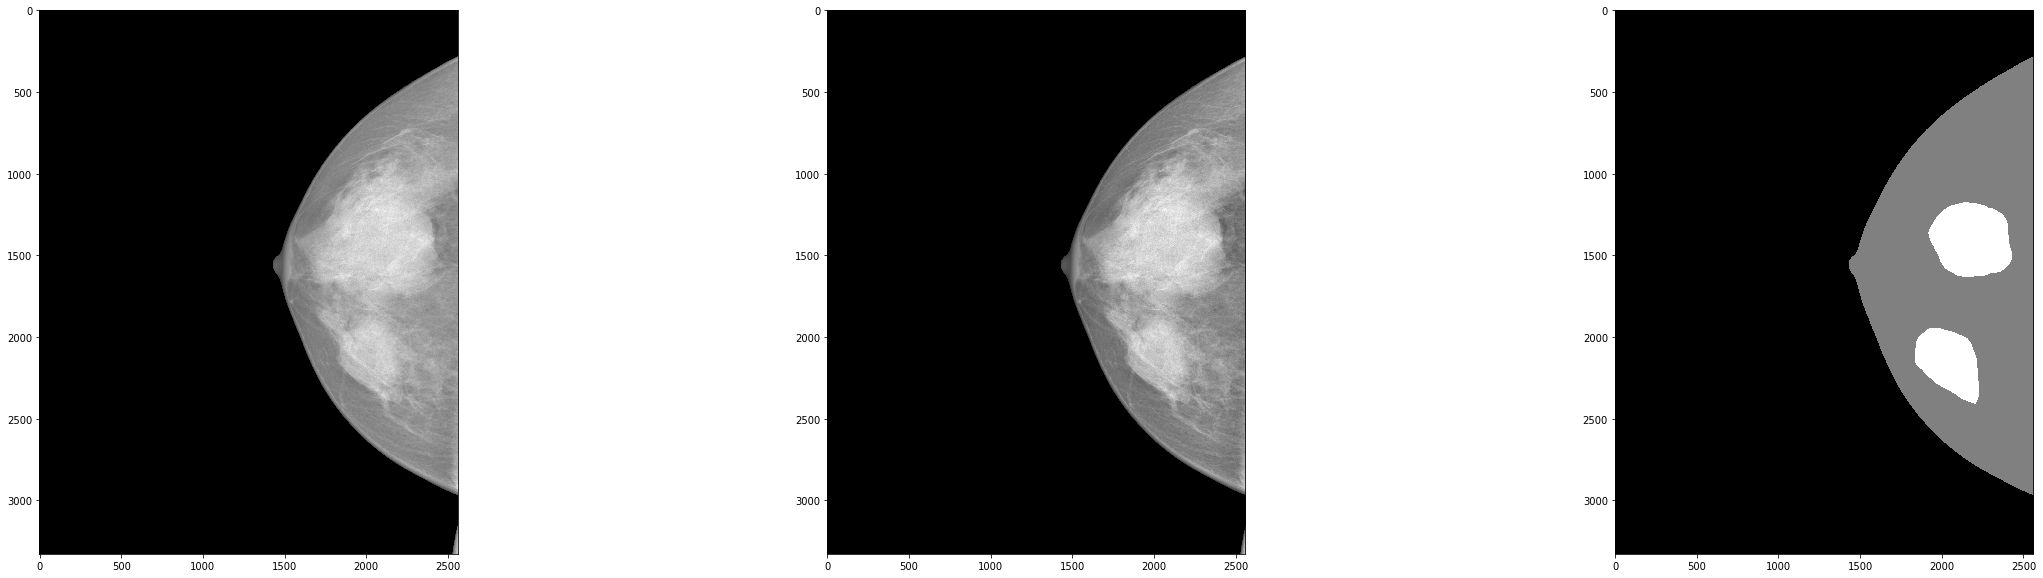

In [4]:
# Load Mammogram, Mask, Label
patient_index            = 64
subject_id               = image_files[patient_index].split('.tif')[0]
image                    = plt.imread(dataset_path+'images/'+image_files[patient_index])
clahe_image              = clahe(image,clip=8,tile=4)
mask                     = plt.imread(dataset_path+'masks/'+subject_id+'.mask.png')
if os.path.exists(dataset_path+'groundtruth/'+subject_id+'.tif'):
    label                = plt.imread(dataset_path+'groundtruth/'+subject_id+'.tif')
    mask[label!=0]       = 2
    classes              = 3
    class_weights        = [0,0.5,1.5]
else:
    classes              = 2
    class_weights        = [0,2]

plt.figure(figsize=(40,10))
plt.subplot(131), plt.imshow(image,       cmap='gray')
plt.subplot(132), plt.imshow(clahe_image, cmap='gray')
plt.subplot(133), plt.imshow(mask,        cmap='gray', vmin=0, vmax=2)
plt.show()

## Morphological Enhancement (*Multi-Scale Morphological Sifting*)

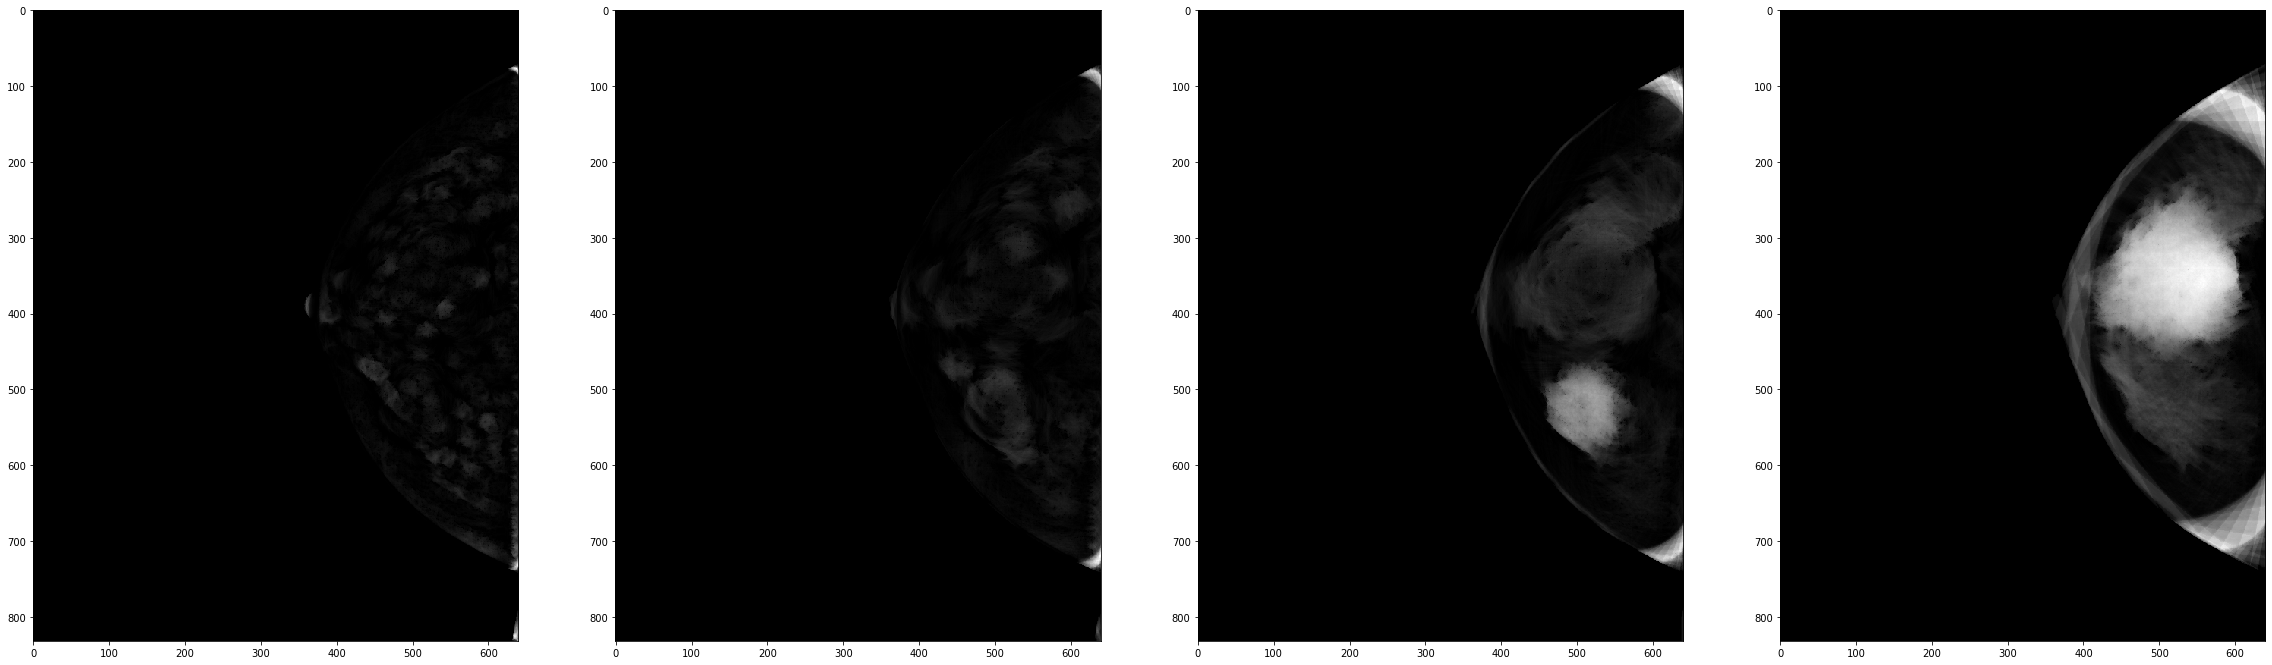

In [5]:
# Morphological Enhancement
down_img     = cv2.resize(clahe_image, None, fx = 1/4, fy = 1/4, interpolation = cv2.INTER_CUBIC)
down_mask    = cv2.resize(mask, None, fx = 1/4, fy = 1/4, interpolation = cv2.INTER_CUBIC)
sifted_image = multi_scale_morphological_sifters(down_img,4,18,15,3689,70/1000)

plt.figure(figsize=(40,20))
plt.subplot(141), plt.imshow(sifted_image[0], cmap='gray')
plt.subplot(142), plt.imshow(sifted_image[1], cmap='gray')
plt.subplot(143), plt.imshow(sifted_image[2], cmap='gray')
plt.subplot(144), plt.imshow(sifted_image[3], cmap='gray')
plt.show()

## Region-Of-Interest (ROI) Segmentation (*SLIC Superpixels*)

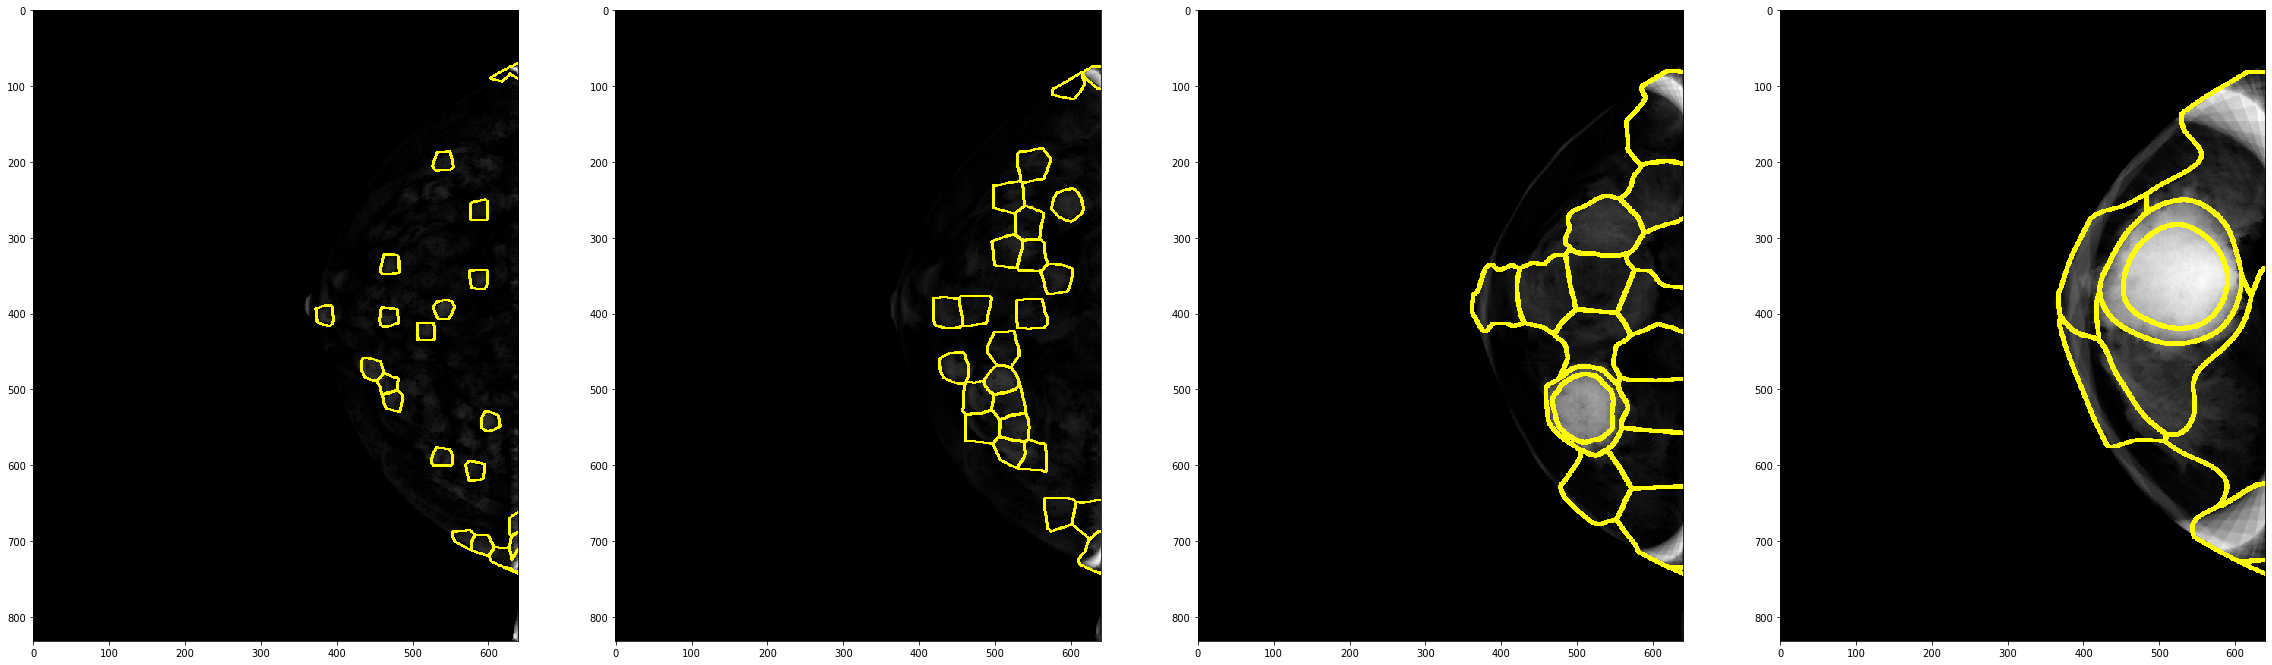

In [6]:
num_pixels        = 4*sifted_image[1].shape[0]*sifted_image[1].shape[1]*70/1000 
DImin             = (math.sqrt(15/math.pi))    # Calculate Minimum Diameter
DImax             = (math.sqrt(3689/math.pi))  # Calculate Maximum Diameter
num_segments      = (np.divide(num_pixels,(np.multiply([12,20,36,62],[12,20,36,62])))).astype(np.int32)
sigma             = [5,5,5,20]
compact_factor    = [10000,10000,10000,8000]
superpixel_thresh = [35,70,250,1000]
                                                                                   
superpixels       = []
for i in range(4):
    # SLIC Superpixel Segmentation
    sift_superpixel = slic(sifted_image[i].astype(np.float), n_segments=num_segments[i], 
                           compactness=compact_factor[i],    sigma=sigma[i])
    sift_superpixel[down_mask==0] = 0   # Mask Out Background Superpixels
    # For Each Superpixel in Breast
    for j in range(sift_superpixel.max()):      
        candidate_superpixel = (sift_superpixel == j)
        total_intensities    = np.sum(np.multiply(sifted_image[i].astype(np.float)/65535,candidate_superpixel))
        if (total_intensities < superpixel_thresh[i]):  sift_superpixel[sift_superpixel==j] = 0
    superpixels.append(sift_superpixel)

plt.figure(figsize=(40,20))
plt.subplot(141), plt.imshow(mark_boundaries(sifted_image[0]/65535, superpixels[0], line_width=3),cmap='gray')
plt.subplot(142), plt.imshow(mark_boundaries(sifted_image[1]/65535, superpixels[1], line_width=3),cmap='gray')
plt.subplot(143), plt.imshow(mark_boundaries(sifted_image[2]/65535, superpixels[2], line_width=5),cmap='gray')
plt.subplot(144), plt.imshow(mark_boundaries(sifted_image[3]/65535, superpixels[3], line_width=5),cmap='gray')
plt.show()

## Patch Extraction (*Guided*)

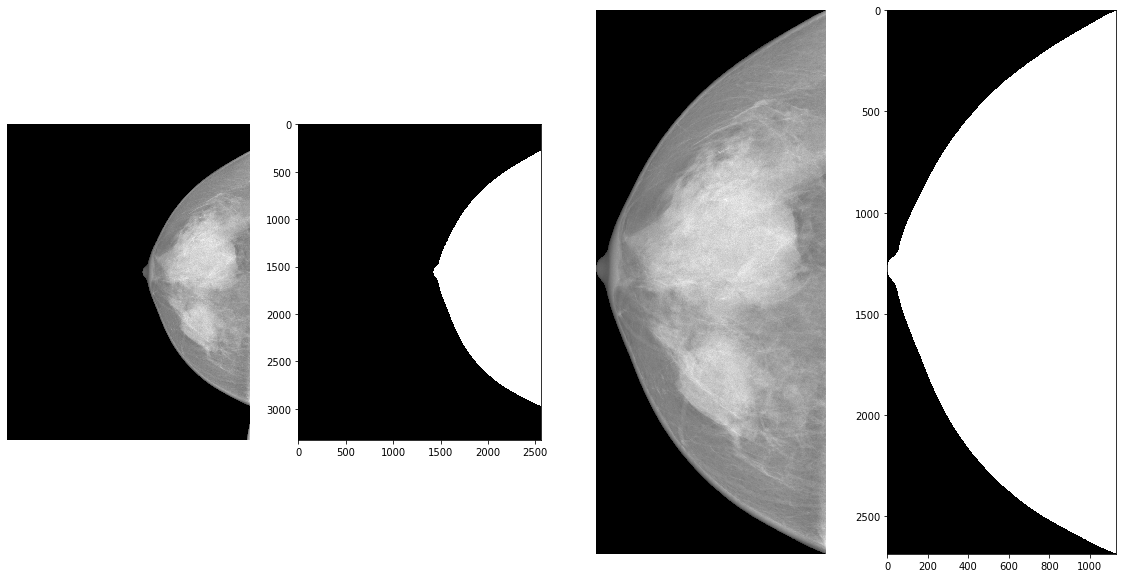

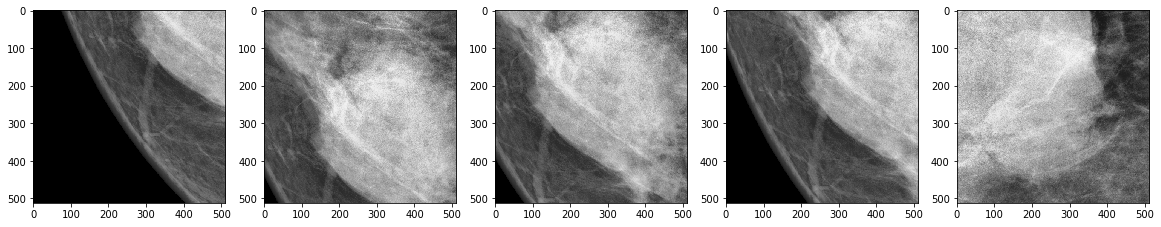

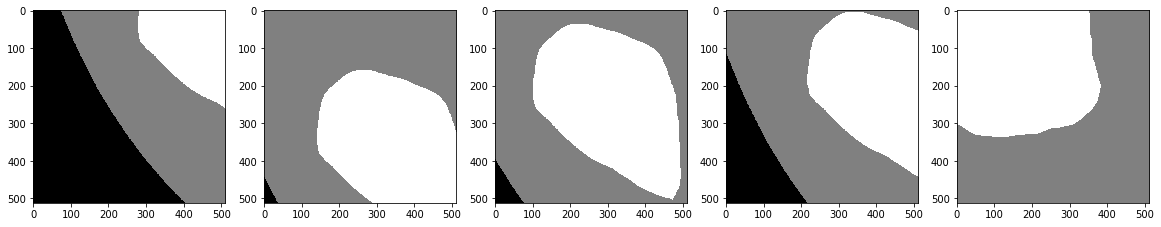

In [7]:
# Bounding Box Generation
bbox_image, bbox_mask    = crop_bbox(image,mask)
clahe_image              = np.expand_dims(normalise_zero_one(clahe(bbox_image, clip=64, tile=4)),axis=-1)    
patches_img, patches_lbl = extract_class_balanced_example_array(clahe_image, bbox_mask, 
                                                                example_size  = [512,512], 
                                                                n_examples    =  5, 
                                                                classes       =  classes, 
                                                                class_weights =  class_weights)

plt.figure(figsize=(20,10))
plt.subplot(141), plt.imshow(image,      cmap='gray'), plt.axis('off')
plt.subplot(142), plt.imshow(mask,       cmap='gray', vmin=0, vmax=1)
plt.subplot(143), plt.imshow(bbox_image, cmap='gray'), plt.axis('off')
plt.subplot(144), plt.imshow(bbox_mask,  cmap='gray', vmin=0, vmax=1)
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(151), plt.imshow(patches_img[0,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.subplot(152), plt.imshow(patches_img[1,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.subplot(153), plt.imshow(patches_img[2,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.subplot(154), plt.imshow(patches_img[3,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.subplot(155), plt.imshow(patches_img[4,:,:,0], cmap='gray', vmin=0, vmax=1)
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(151), plt.imshow(patches_lbl[0,:,:], cmap='gray', vmin=0, vmax=2)
plt.subplot(152), plt.imshow(patches_lbl[1,:,:], cmap='gray', vmin=0, vmax=2)
plt.subplot(153), plt.imshow(patches_lbl[2,:,:], cmap='gray', vmin=0, vmax=2)
plt.subplot(154), plt.imshow(patches_lbl[3,:,:], cmap='gray', vmin=0, vmax=2)
plt.subplot(155), plt.imshow(patches_lbl[4,:,:], cmap='gray', vmin=0, vmax=2)
plt.show()